In [1]:
import os
import glob
import netCDF4
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from scipy import stats

from matplotlib.collections import LineCollection
from matplotlib.path import Path
import matplotlib.path as mpath
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import matplotlib.colors as colors

In [2]:
##Join PCP_max archives
os.chdir('D:\\Bigfiles\\ERA5_PCP')
lats = np.genfromtxt('PCP_max_lats.csv', delimiter=';')
lons = np.genfromtxt('PCP_max_lons.csv', delimiter=';')
duration = np.genfromtxt('PCP_max_duration.csv', delimiter=';')

PCP_max = np.zeros((lats.shape[0], lons.shape[0], 20))
PCP_mean = np.zeros((lats.shape[0], lons.shape[0], 20))


files = 'ERA5_PCP_max_*d.csv'
for i,file in enumerate(glob.glob(files)):
    print(file)
    PCP_max[:,:,i] = np.genfromtxt(file, delimiter=';')

    
Ant_max = np.max(np.max(PCP_max, axis=0), axis=0)
Ant_mean = np.mean(np.mean(PCP_mean, axis=0), axis=0)
print(Ant_max)
print(duration)

ERA5_PCP_max_001d.csv
ERA5_PCP_max_002d.csv
ERA5_PCP_max_003d.csv
ERA5_PCP_max_004d.csv
ERA5_PCP_max_005d.csv
ERA5_PCP_max_006d.csv
ERA5_PCP_max_007d.csv
ERA5_PCP_max_008d.csv
ERA5_PCP_max_009d.csv
ERA5_PCP_max_010d.csv
ERA5_PCP_max_015d.csv
ERA5_PCP_max_020d.csv
ERA5_PCP_max_030d.csv
ERA5_PCP_max_060d.csv
ERA5_PCP_max_090d.csv
ERA5_PCP_max_180d.csv
ERA5_PCP_max_270d.csv
ERA5_PCP_max_365d.csv
ERA5_PCP_max_545d.csv
ERA5_PCP_max_730d.csv
[ 110.3515625   184.10110474  220.96252441  269.8135376   288.25759888
  302.22320557  343.73474121  366.22238159  393.84841919  415.94314575
  528.49960327  659.53445435  850.92926025 1256.21032715 1649.47509766
 2716.20368958 3569.99206543 4266.57104492 5936.55395508 7812.53433228]
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  15.  20.  30.  60.
  90. 180. 270. 365. 545. 730.]


ANTARCTICA
LinregressResult(slope=0.6319177263467192, intercept=0.04270489012997203, rvalue=0.9982908853111473, pvalue=1.1743911392881616e-23, stderr=0.008719310367925018)
[0.63191773 0.04270489]
LinregressResult(slope=0.6319177263467192, intercept=0.04270489012997203, rvalue=0.9982908853111473, pvalue=1.1743911392881616e-23, stderr=0.008719310367925018)
a_sup = [1.22343872], a_inf = [0.95409544]
a = 0.04270489012997035
b = 0.6319177263467193
[ 121.17344838  187.77322171  242.61008265  290.97779475  335.04180771
  375.95428246  414.41922984  450.9060252   485.74710871  519.18865464
  670.81131838  804.54693386 1039.50497488 1610.84132482 2081.26773022
 3225.18135926 4167.05592521 5041.56938347 6495.08626265 7812.53433228]
WR
LinregressResult(slope=0.4865040448101741, intercept=3.9649359530978723, rvalue=0.9967063240751914, pvalue=2.8804579636898835e-45, stderr=0.006258738050485183)
LinregressResult(slope=0.4865040448101741, intercept=3.9649359530978723, rvalue=0.9967063240751914, pvalu

<ipython-input-4-1c60be501676>:174: MatplotlibDeprecationWarning: The 'subsx' parameter of __init__() has been renamed 'subs' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax2.set_xscale('log', subsx=[0])


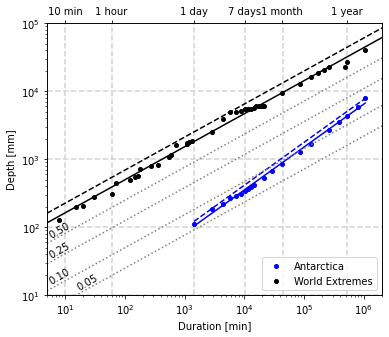

In [4]:
######################################
# Plot Scaling Law of Continental Mean
######################################

#Obtain max array
#Ant_mean = np.mean(np.mean(PCP_mean, axis=0), axis=0)

class SL_Envelop():
    '''----BASIC METHODS----'''
    def __init__(self, duration, record):
        self._duration = duration
        self._record = record
        
    @property
    def duration (self):
        return self._duration     
    
    @property
    def record (self):
        return self._record
     
    def __str__(self):
        return 'DATA\n Duration: ' + self.duration + '\n Record: ' + self.record
    
    def regression(self, complete=False, ftype=0):
        '''Log-Log regression of data'''
        #Fit in log domain
        p = np.polyfit(np.log(self.duration),np.log(self.record),1)
        #lm = LinearRegression()
        print(stats.linregress(np.log(self.duration), np.log(self.record)))
        
        #Compute fit in linear domain (y = e^(p_1 * log(x) + p_2)
        if complete == False:
            y_hat = np.exp(p[0] * np.log(self.duration) + p[1])
        else:
            y_hat = np.exp(p[0] * np.log([1,10000000]) + p[1])
        
        if ftype == 3:
            return y_hat, p[1], p[0]
        elif ftype == 2:
            return p[1], p[0]      
        elif ftype == 1:
            return np.exp(p[1]), p[0]
        else:
            return y_hat, p
    
    def envelope(self, opt='both', range=[1,10000000], complete=False):
        '''Envelop of the supINSay data'''
        
        #Make the regression
        y_hat, a, b = self.regression(complete=False, ftype=3)
        
        #Superior Envelop
        Log_record_sup = np.log(self.record[np.where(self.record > y_hat)])
        Log_duration_sup = np.log(self.duration[np.where(self.record > y_hat)])
        dist = np.abs(b*Log_duration_sup - Log_record_sup + a) / np.sqrt(b**2 + 1)
        Max_record_sup = Log_record_sup[np.where(dist == np.amax(dist))]
        Max_duration_sup = Log_duration_sup[np.where(dist == np.amax(dist))]
        a_sup = b*(-Max_duration_sup) + Max_record_sup

        #Inferior Envelop
        Log_record_inf = np.log(self.record[np.where(self.record < y_hat)])
        Log_duration_inf = np.log(self.duration[np.where(self.record < y_hat)])
        dist = np.abs(b*Log_duration_inf - Log_record_inf + a) / np.sqrt(b**2 + 1)
        Max_record_inf = Log_record_inf[np.where(dist == np.amax(dist))]
        Max_duration_inf = Log_duration_inf[np.where(dist == np.amax(dist))]
        a_inf = b*(-Max_duration_inf) + Max_record_inf

        
        #Calculate the Envelope ecuation
        if complete == False:
            y_hat_sup = np.exp(b * np.log(self.duration) + a_sup)
            y_hat_inf = np.exp(b * np.log(self.duration) + a_inf)
        else:
            y_hat_sup = np.exp(b * np.log(range) + a_sup)
            y_hat_inf = np.exp(b * np.log(range) + a_inf)
        
        print('a_sup = ' + str(np.exp(a_sup)) + ', a_inf = ' + str(np.exp(a_inf)))
        print('a = ' + str(a))
        print('b = ' + str(b))
        print(y_hat_sup)
        
        return y_hat_sup, y_hat_inf, a_sup, a_inf, b
        
        #return env_sup, env_inf 
        
    
    def formula(self, ftype=0):
        '''Show formula of regression'''
        _reg, p = self.regression()
        R2 = self.R2()
        b = p[0]
        a = np.exp(p[1])        
        
        #formula = 'y = '+str(np.round(a,2))+' EXP(x^'+str(np.round(b,2))+')'
        if ftype == 0:
            formula = '$y = '+str(np.round(a,2))+' x^{'+str(np.round(b,2))+'}$'
        elif ftype == 1:
            formula = '$b:'+str(np.round(b,2))+'$'
        elif ftype == 2:
            formula = '$b:'+str(np.round(b,2))+' a:'+str(np.round(a,2))+'$'
        elif ftype == 3:
            formula = '$R^{2}:'+str(np.round(R2,2))+'$'
        
        return formula
    
    def exponent(self):
        _reg, p = self.regression()
        b = p[0]
        
        return b
    
    def R2(self):
        X = np.log(np.array(self.duration))
        Y = np.log(np.array(self.record))
        n = np.size(X)
        A = np.sum(X*Y) - 1/n * np.sum(X) * np.sum(Y)
        B = np.sum(X**2) - 1/n * np.sum(X)**2
        C = np.sum(Y**2) - 1/n * np.sum(Y)**2
        
        return A**2 / (B*C)
    
       
def plot_scaling_law():    
    #SETTING LINES##
    #Axis
    fig = plt.figure(figsize=(6,5))
    ax = fig.gca()
    ylines = [10,100,1000,10000]
    xlines = [10,60,1440,10080,44640,525600]
    for yline in ylines:
        ax.axhline(yline, linestyle='--', linewidth=1.5, color='LightGray')
    for xline in xlines:
        ax.axvline(xline, linestyle='--', linewidth=1.5, color='LightGray')

    ###ANTARCTICA###
    print('ANTARCTICA')
    #BD = get_sl_data('Spain')
    BDdata = SL_Envelop(duration*1440, Ant_max)
    plt.plot(duration*1440, Ant_max, '.', color='b', markersize=8, label='Antarctica')
    y_hat, _pBD= BDdata.regression()
    print(_pBD)
    plt.loglog(duration*1440,y_hat,'-', color = 'b', linewidth=1.5)
    y_hat_sup, _y_hat_inf, _a_sup, _a_inf, _b = BDdata.envelope(range=[10,100000])    
    plt.loglog(duration*1440,y_hat_sup,'--', color = 'b', linewidth=1.5)
    #plt.loglog([10,1000000],y_hat_sup,'-', color = 'g', label='Spain')
    #print(BD)
    
    ###WORLD RECORDS###
    print('WR')
    BD = get_sl_data('WR')
    BDdata = SL_Envelop(BD[0,:],BD[1,:])
    plt.plot(BD[0,:],BD[1,:], '.', color = 'k', markersize=8, label='World Extremes')
    y_hat, _pBD= BDdata.regression(complete=True)
    plt.loglog([1,10000000],y_hat,'-', color = 'k', linewidth=1.5)
    y_hat_sup, _y_hat_inf, _a_sup, _a_inf, _b = BDdata.envelope(complete=True)    
    plt.loglog([1,10000000],y_hat_sup,'--', color = 'k', linewidth=1.5)

    #Percent of max value
    plt.plot([1,10000000],y_hat*0.50,':', color='Gray') #50% of max values
    plt.plot([1,10000000],y_hat*0.25,':', color='Gray') #25% of max values
    plt.plot([1,10000000],y_hat*0.10,':', color='Gray') #10% of max values
    plt.plot([1,10000000],y_hat*0.05,':', color='Gray') #05% of max values
    plt.text(5,65,'0.50', fontsize=10, rotation=30, verticalalignment='bottom')
    plt.text(5,33,'0.25', fontsize=10, rotation=30, verticalalignment='bottom')
    plt.text(5,13.5,'0.10', fontsize=10, rotation=30, verticalalignment='bottom')   
    plt.text(15,11,'0.05', fontsize=10, rotation=30, verticalalignment='bottom')   
    plt.legend()
    
    ###PLOT SETTINGS###
    ax.set_xscale("log")#, nonposy="clip")
    ax.set_yscale("log")#, nonposy="clip")
    ax2 = ax.twiny() #Repit axis on top
    ax2.set_xscale('log', subsx=[0])
    #axarr[i,j].set_xscale('log')
    #axarr[i,j].set_yscale('log')
    ax.set_xlabel('Duration [min]', fontsize=10)
    ax.set_ylabel('Depth [mm]', fontsize=10)
    ax2.set_xticks([10, 60, 1440, 10080, 43200, 525600])
    ax2.set_xticklabels(['10 min', '1 hour', '1 day', '7 days', '1 month', '1 year'])
    ax.tick_params(axis='both', labelsize=10)
    ax2.tick_params(axis='both', labelsize=10)
    
    #General
    ax.set_xlim(5, 2000000)
    ax2.set_xlim(5, 2000000)
    #plt.xlim(1,2000000)
    plt.ylim(10,100000)
    ax.legend(loc=4, fontsize=10)
    #os.chdir('D:\\MEGA\\UBUNTU\\Figures\\Antarctica_ScaleLaw')
    plt.savefig('Envelope_Antarctica.png', dpi=300)

def get_sl_data(country):
    #Folder
    os.chdir('D:\\Bigfiles\\ERA5_PCP')
    #Read data
    BD = np.loadtxt('Max_'+country+'.csv',delimiter=';')    
    return BD    

plot_scaling_law()

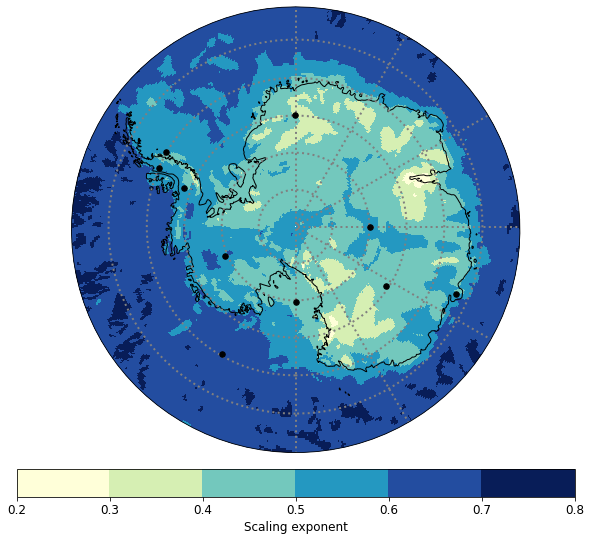

In [6]:
######################################
# Plot Scaling Law Map of Antarctica
######################################

##Create a matrix of exponents
b_matrix = np.zeros(PCP_max[:,:,0].shape)
for i in range(PCP_max.shape[0]):
    for j in range(PCP_max.shape[1]):
        b, a = np.polyfit(np.log(duration),np.log(PCP_max[i,j,:]),1)
        b_matrix[i,j] = b


##Plot
plt.close('all')

#Map parameters
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo(central_longitude=0))
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
#Set circle boundary
theta=np.linspace(0, 2*np.pi, 100)
center, radius = [0.5,0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts*radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
#ax.add_feature(cartopy.feature.LAND)
#ax.add_feature(cartopy.feature.OCEAN)
#ax.stock_img()
ax.coastlines(resolution='50m', color='black', linewidth=1)
gl = ax.gridlines(color='gray', linestyle=':', linewidth=2)
gl.n_steps = 90
gl.xlocator = mticker.FixedLocator([0,30,60,90,120,150,180,210,240,270,300,330,360])
gl.ylocator = mticker.FixedLocator([-60,-65,-70,-75,-80,-85,-90])

#Plot b_matrix
cmap = plt.get_cmap('YlGnBu')
bounds = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]
norm = colors.BoundaryNorm(bounds, cmap.N)
cs = ax.pcolormesh(lons, lats, b_matrix, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar = fig.colorbar(cs, pad=0.03, orientation='horizontal')
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Scaling exponent', fontsize=12)

#Plot points
p_lats = np.array([-75.00, -79.85, -66.73, -75.35, -79.85, -70.26, -79.68, -74.06, -70.01, -69.88])
p_lons = np.array([-0.33, 90.02, 112.75, 123.33, 179.83, -149.99, -112.33, -70.86, -66.73, -60.02])
#ax.plot(p_lons[:], p_lats[:], 'k.', transform=ccrs.PlateCarree())
ax.scatter(p_lons, p_lats, marker='o', c='k', s=30, transform=ccrs.PlateCarree(), zorder=200)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


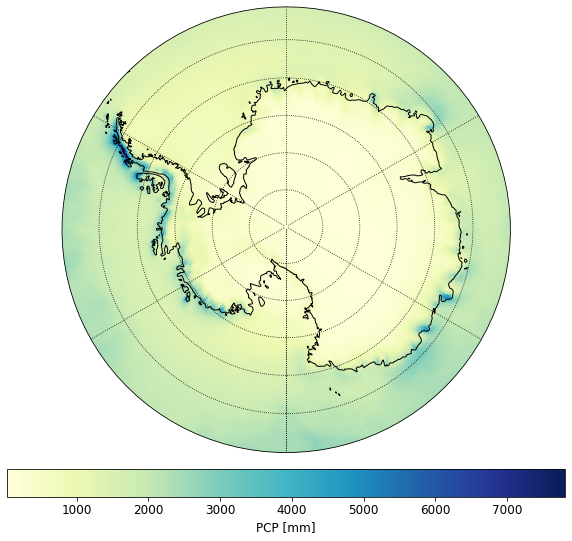

In [10]:
######################################
# Plot Max PCP Map of Antarctica
######################################

##Plot
plt.close('all')

#Map parameters
for j in range(20):
    print(j)
    plt.close('all')
    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo(central_longitude=0))
    ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
    #Set circle boundary
    theta=np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5,0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts*radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    #ax.add_feature(cartopy.feature.LAND)
    #ax.add_feature(cartopy.feature.OCEAN)
    #ax.stock_img()
    ax.coastlines()
    gl = ax.gridlines(color='k', linestyle=':')
    gl.n_steps = 90

    #Plot b_matrix
    cmap = plt.get_cmap('YlGnBu')
    cs = ax.pcolormesh(lons, lats, PCP_max[:,:,j], cmap=cmap, transform=ccrs.PlateCarree())
    cbar = fig.colorbar(cs, pad=0.03, orientation='horizontal')
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('PCP [mm]', fontsize=12)

    #os.chdir('D:\\MEGA\\UBUNTU\\Figures\\Antarctica_ScaleLaw')
    plt.savefig('Maps_PCP_'+str(j)+'.png', dpi=300)

[ 10.75708866  13.19861412  16.0844326   16.67988205  17.05312729
  18.9409256   20.28739548  22.1760273   24.23191071  26.11970901
  27.2744894   27.51195431  29.74689102  36.07416153  43.81036758
  60.46628952  78.42457294  99.10190105 125.01597404 169.66617107]
ANTARCTICA
a_sup = [0.82856008], a_inf = [0.45966412]
b = 0.3838246468104467
[ 13.50769897  17.62479626  20.59265154  22.99676976  25.0532048
  26.86921648  28.50695501  30.00610114  31.39374799  32.68933007
  38.19391574  42.65291843  49.83528169  65.02489345  75.97449369
  99.13124174 115.82404062 130.03268412 151.66235472 169.66617107]
WR
a_sup = [73.09949937], a_inf = [39.78465765]
b = 0.4865040448101739
[7.30994994e+01 1.85969925e+05]


<ipython-input-8-b8d14d5faf04>:187: MatplotlibDeprecationWarning: The 'subsx' parameter of __init__() has been renamed 'subs' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax2.set_xscale('log', subsx=[0])


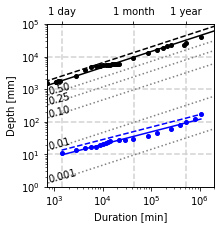

In [8]:
######################################
# Plot Scaling Law of a point
######################################

args_7500S_033W_DronningMaudLand = [60, 719]
args_7985S_9002E_HighPlateau = [79, 1080]
args_6673S_11275E_LawDome = [27, 1171]
args_7535S_12333E_DomeC = [61, 1213]
args_7985S_17983E_RossIceShelf = [79, 1439]
args_7026S_14999W_Ocean = [41, 120]
args_7968S_11233W_WAISDivide = [ 79, 271]
args_7406S_7086W_Gomez = [ 56, 437]
args_7001S_6673W_WestPeninsula = [ 40, 453]
args_6988S_6002W_EastPeninsula = [ 40, 480]

#print(lons[args_m90_m170args_m7985_m09002[0],args_m7985_m09002[1]]); print(lats[args_m90_m170args_m7985_m09002[0],args_m7985_m09002[1]])
point = args_7500S_033W_DronningMaudLand
pointname = 'DronningMaudLand'
PCPmax_args = PCP_max[point[0],point[1],:]
print(PCPmax_args)


class SL_Envelop():
    '''----BASIC METHODS----'''
    def __init__(self, duration, record):
        self._duration = duration
        self._record = record
        
    @property
    def duration (self):
        return self._duration     
    
    @property
    def record (self):
        return self._record
     
    def __str__(self):
        return 'DATA\n Duration: ' + self.duration + '\n Record: ' + self.record
    
    def regression(self, complete=False, ftype=0):
        '''Log-Log regression of data'''
        #Fit in log domain
        p = np.polyfit(np.log(self.duration),np.log(self.record),1)
        
        #Compute fit in linear domain (y = e^(p_1 * log(x) + p_2)
        if complete == False:
            y_hat = np.exp(p[0] * np.log(self.duration) + p[1])
        else:
            y_hat = np.exp(p[0] * np.log([1,10000000]) + p[1])
        
        if ftype == 3:
            return y_hat, p[1], p[0]
        elif ftype == 2:
            return p[1], p[0]      
        elif ftype == 1:
            return np.exp(p[1]), p[0]
        else:
            return y_hat, p
    
    def envelope(self, opt='both', range=[1,10000000], complete=False):
        '''Envelop of the supINSay data'''
        
        #Make the regression
        y_hat, a, b = self.regression(complete=False, ftype=3)
        
        #Superior Envelop
        Log_record_sup = np.log(self.record[np.where(self.record > y_hat)])
        Log_duration_sup = np.log(self.duration[np.where(self.record > y_hat)])
        dist = np.abs(b*Log_duration_sup - Log_record_sup + a) / np.sqrt(b**2 + 1)
        Max_record_sup = Log_record_sup[np.where(dist == np.amax(dist))]
        Max_duration_sup = Log_duration_sup[np.where(dist == np.amax(dist))]
        a_sup = b*(-Max_duration_sup) + Max_record_sup

        #Inferior Envelop
        Log_record_inf = np.log(self.record[np.where(self.record < y_hat)])
        Log_duration_inf = np.log(self.duration[np.where(self.record < y_hat)])
        dist = np.abs(b*Log_duration_inf - Log_record_inf + a) / np.sqrt(b**2 + 1)
        Max_record_inf = Log_record_inf[np.where(dist == np.amax(dist))]
        Max_duration_inf = Log_duration_inf[np.where(dist == np.amax(dist))]
        a_inf = b*(-Max_duration_inf) + Max_record_inf

        
        #Calculate the Envelope ecuation
        if complete == False:
            y_hat_sup = np.exp(b * np.log(self.duration) + a_sup)
            y_hat_inf = np.exp(b * np.log(self.duration) + a_inf)
        else:
            y_hat_sup = np.exp(b * np.log(range) + a_sup)
            y_hat_inf = np.exp(b * np.log(range) + a_inf)
        
        print('a_sup = ' + str(np.exp(a_sup)) + ', a_inf = ' + str(np.exp(a_inf)))
        print('b = ' + str(b))
        print(y_hat_sup)
        
        return y_hat_sup, y_hat_inf, a_sup, a_inf, b
        
        #return env_sup, env_inf 
        
    
    def formula(self, ftype=0):
        '''Show formula of regression'''
        _reg, p = self.regression()
        R2 = self.R2()
        b = p[0]
        a = np.exp(p[1])        
        
        #formula = 'y = '+str(np.round(a,2))+' EXP(x^'+str(np.round(b,2))+')'
        if ftype == 0:
            formula = '$y = '+str(np.round(a,2))+' x^{'+str(np.round(b,2))+'}$'
        elif ftype == 1:
            formula = '$b:'+str(np.round(b,2))+'$'
        elif ftype == 2:
            formula = '$b:'+str(np.round(b,2))+' a:'+str(np.round(a,2))+'$'
        elif ftype == 3:
            formula = '$R^{2}:'+str(np.round(R2,2))+'$'
        
        return formula
    
    def exponent(self):
        _reg, p = self.regression()
        b = p[0]
        
        return b
    
    def R2(self):
        X = np.log(np.array(self.duration))
        Y = np.log(np.array(self.record))
        n = np.size(X)
        A = np.sum(X*Y) - 1/n * np.sum(X) * np.sum(Y)
        B = np.sum(X**2) - 1/n * np.sum(X)**2
        C = np.sum(Y**2) - 1/n * np.sum(Y)**2
        
        return A**2 / (B*C)
    
       
def plot_scaling_law(PCPmax, point):    
    #SETTING LINES##
    #Axis
    fig = plt.figure(figsize=(3,3))
    ax = fig.gca()
    ylines = [10,100,1000,10000]
    xlines = [10,60,1440,44640,525600]
    for yline in ylines:
        ax.axhline(yline, linestyle='--', linewidth=1.5, color='LightGray')
    for xline in xlines:
        ax.axvline(xline, linestyle='--', linewidth=1.5, color='LightGray')

    ###ANTARCTICA###
    print('ANTARCTICA')
    #BD = get_sl_data('Spain')
    BDdata = SL_Envelop(duration*1440, PCPmax)
    plt.plot(duration*1440, PCPmax, '.', color='b', markersize=8, label='Antarctica')
    y_hat, _pBD= BDdata.regression()
    plt.loglog(duration*1440,y_hat,'-', color = 'b', linewidth=1.5)
    y_hat_sup, _y_hat_inf, _a_sup, _a_inf, _b = BDdata.envelope(range=[10,100000])    
    plt.loglog(duration*1440,y_hat_sup,'--', color = 'b', linewidth=1.5)
    #plt.loglog([10,1000000],y_hat_sup,'-', color = 'g', label='Spain')
    #print(BD)
    
    ###WORLD RECORDS###
    print('WR')
    BD = get_sl_data('WR')
    BDdata = SL_Envelop(BD[0,:],BD[1,:])
    plt.plot(BD[0,:],BD[1,:], '.', color = 'k', markersize=8, label='World Extremes')
    y_hat, _pBD= BDdata.regression(complete=True)
    plt.loglog([1,10000000],y_hat,'-', color = 'k', linewidth=1.5)
    y_hat_sup, _y_hat_inf, _a_sup, _a_inf, _b = BDdata.envelope(complete=True)    
    plt.loglog([1,10000000],y_hat_sup,'--', color = 'k', linewidth=1.5)

    #Percent of max value
    plt.plot([1,10000000],y_hat*0.50,':', color='Gray') #50% of max values
    plt.plot([1,10000000],y_hat*0.25,':', color='Gray') #25% of max values
    plt.plot([1,10000000],y_hat*0.10,':', color='Gray') #10% of max values
    plt.plot([1,10000000],y_hat*0.01,':', color='Gray') #1% of max values
    plt.plot([1,10000000],y_hat*0.001,':', color='Gray') #0.1% of max values
    plt.text(720,600,'0.50', fontsize=10, rotation=15, verticalalignment='bottom')
    plt.text(720,300,'0.25', fontsize=10, rotation=15, verticalalignment='bottom')
    plt.text(720,120,'0.10', fontsize=10, rotation=15, verticalalignment='bottom')
    plt.text(720,12,'0.01', fontsize=10, rotation=15, verticalalignment='bottom')
    plt.text(720,1.2,'0.001', fontsize=10, rotation=15, verticalalignment='bottom')
    #plt.legend()
    
    ###PLOT SETTINGS###
    ax.set_xscale("log")#, nonposy="clip")
    ax.set_yscale("log")#, nonposy="clip")
    ax2 = ax.twiny() #Repit axis on top
    ax2.set_xscale('log', subsx=[0])
    #axarr[i,j].set_xscale('log')
    #axarr[i,j].set_yscale('log')
    ax.set_xlabel('Duration [min]', fontsize=10)
    ax.set_ylabel('Depth [mm]', fontsize=10)
    ax2.set_xticks([10, 60, 1440, 43200, 525600])
    ax2.set_xticklabels(['10 min', '1 hour', '1 day', '1 month', '1 year'])
    ax.tick_params(axis='both', labelsize=10)
    ax2.tick_params(axis='both', labelsize=10)
    
    #General
    ax.set_xlim(720, 2000000)
    ax2.set_xlim(720, 2000000)
    #plt.xlim(1,2000000)
    plt.ylim(1,100000)
    #ax.legend(loc=4, fontsize=10)
    #os.chdir('D:\\MEGA\\UBUNTU\\Figures\\Antarctica_ScaleLaw')
    plt.savefig('Envelope_'+pointname+'.png', dpi=300)

def get_sl_data(country):
    #Folder
    os.chdir('D:\\Bigfiles\\ERA5_PCP')
    #Read data
    BD = np.loadtxt('Max_'+country+'.csv',delimiter=';')    
    return BD    

plot_scaling_law(PCPmax_args, pointname)

In [9]:


args_lat_7500S_033W = np.argwhere(np.round(lats,2) == -75.00); 
args_lon_7500S_033W = np.argwhere(np.round(lons,2) == -0.25);
print(args_lat_7500S_033W)
print(args_lon_7500S_033W)

args_lat_7985S_9002E = np.argwhere(np.round(lats,2) == -79.75); 
args_lon_7985S_9002E = np.argwhere(np.round(lons,2) == 90.00);
print(args_lat_7985S_9002E)
print(args_lon_7985S_9002E)

args_lat_6673S_11275E = np.argwhere(np.round(lats,2) == -66.75); 
args_lon_6673S_11275E = np.argwhere(np.round(lons,2) == 112.75);
print(args_lat_6673S_11275E)
print(args_lon_6673S_11275E)

args_lat_7535S_12333E = np.argwhere(np.round(lats,2) == -75.25); 
args_lon_7535S_12333E = np.argwhere(np.round(lons,2) == 123.25);
print(args_lat_7535S_12333E)
print(args_lon_7535S_12333E)

args_lat_7985S_17983E = np.argwhere(np.round(lats,2) == -79.75); 
args_lon_7985S_17983E = np.argwhere(np.round(lons,2) == 179.75);
print(args_lat_7985S_17983E)
print(args_lon_7985S_17983E)

args_lat_7026S_14999W = np.argwhere(np.round(lats,2) == -70.25); 
args_lon_7026S_14999W = np.argwhere(np.round(lons,2) == -150.00);
print(args_lat_7026S_14999W)
print(args_lon_7026S_14999W)

args_lat_7968S_11233W = np.argwhere(np.round(lats,2) == -79.75); 
args_lon_7968S_11233W = np.argwhere(np.round(lons,2) == -112.25);
print(args_lat_7968S_11233W)
print(args_lon_7968S_11233W)

args_lat_7406S_7086W = np.argwhere(np.round(lats,2) == -74.00); 
args_lon_7406S_7086W = np.argwhere(np.round(lons,2) == -70.75);
print(args_lat_7406S_7086W)
print(args_lon_7406S_7086W)

args_lat_7001S_6673W = np.argwhere(np.round(lats,2) == -70.00); 
args_lon_7001S_6673W = np.argwhere(np.round(lons,2) == -66.75);
print(args_lat_7001S_6673W)
print(args_lon_7001S_6673W)

args_lat_6988S_6002W = np.argwhere(np.round(lats,2) == -70.00); 
args_lon_6988S_6002W = np.argwhere(np.round(lons,2) == -60.00);
print(args_lat_6988S_6002W)
print(args_lon_6988S_6002W)

args_7500S_033W_DronningMaudLand = [60, 719]
args_7985S_9002E_HighPlateau = [79, 1080]
args_6673S_11275E_LawDome = [27, 1171]
args_7535S_12333E_DomeC = [61, 1213]
args_7985S_17983E_RossIceShelf = [79, 1439]
args_7026S_14999W_Ocean = [41, 120]
args_7968S_11233W_WAISDivide = [ 79, 271]
args_7406S_7086W_Gomez = [ 56, 437]
args_7001S_6673W_WestPeninsula = [ 40, 453]
args_6988S_6002W_EastPeninsula = [ 40, 480]

[[60]]
[[719]]
[[79]]
[[1080]]
[[27]]
[[1171]]
[[61]]
[[1213]]
[[79]]
[[1439]]
[[41]]
[[120]]
[[79]]
[[271]]
[[56]]
[[437]]
[[40]]
[[453]]
[[40]]
[[480]]
